# 0. Initial set up

In [34]:
import os
import sys
import warnings
from SOBER._utils import TensorManager
tm = TensorManager()
sys.path.append(os.path.join(os.getcwd(), '..'))
warnings.filterwarnings('ignore')

# 1. Set up the problem.
## 1.1 define the domain, bounds

In [35]:
import torch
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

# set bounds
bounds = torch.tensor([
    [0, 0], # lower bound 
    [100, 60], # upper bound
]).double()

# set label names
label_names = ["SOC", "Temp"]

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

## 1.2 define the lifetime function

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy.interpolate import Rbf

# We set threshold that defines good/bad battery
threshold_lifetime = 6

#Lifetime function from literature
LiftimeJossen = pd.read_json('PriorKnowledge.json')

# Extract data fields
StorageTemperatures = [data['Storage_Temperature'] for data in LiftimeJossen['data']]
UsedStoredSpecificEnergy = [data['Used_Stored_Specific_Energy'] for data in LiftimeJossen['data']]
LifetimeCoefficients = [data['Lifetime_Coefficient'] for data in LiftimeJossen['data']]
max_UsedStoredSpecificEnergy = max(UsedStoredSpecificEnergy)
Lifetime = [lc / (max_UsedStoredSpecificEnergy * 100 / 365) for lc in LifetimeCoefficients]

rbf = Rbf(StorageTemperatures, UsedStoredSpecificEnergy, Lifetime, function='cubic')

def lifetime_function(X):
    X_np = X.detach().cpu().numpy()
    interpolated_values = rbf(X_np[:, 0], X_np[:, 1])
    return(torch.from_numpy(interpolated_values)).unsqueeze(-1)

# visualising parameters
colour_map = 'inferno'
resolution = 200

def get_plotting_domain():
    x = torch.linspace(bounds[0][0], bounds[1][0], resolution)
    y = torch.linspace(bounds[0][1], bounds[1][1], resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[bounds[0][1], bounds[1][1], bounds[0][0], bounds[1][0]],
        interpolation='nearest',
        origin='lower',
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    #fig.colorbar(aximg, cax=cax)
    cbar = plt.colorbar(image, cax=cax)
    ax.set_xlabel(label_names[1])
    ax.set_ylabel(label_names[0])
    
def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="violet")

def plot_gold(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="gold")

def plot_red(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="o", color="r")

# 2. Set up a Gaussian Process model

In [37]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

def setting_GP_model(X, Y):
    model = SingleTaskGP(X, Y) # setting GP model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll) # optimize GP hyperparameters
    return model

def prediction(model, X):
    X_standardized = torch.tensor(X_scaler.transform(X), dtype=torch.double)
    posterior = model.posterior(X_standardized)
    mean = posterior.mean.squeeze()
    std = posterior.variance.sqrt().squeeze()

    # Compute the standardized threshold
    threshold = torch.tensor((0 - Y_scaler.mean_) / Y_scaler.scale_, dtype=torch.double)

    #prob = torch.distributions.Normal(0,1).cdf(posterior.mean.squeeze() / posterior.stddev)
    prob = 1 - torch.distributions.Normal(mean, std).cdf(threshold)

    var = prob * (1 - prob) # Bernoulli likelihood
    return prob, var, posterior.stddev

## 2.1 generate the initial dataset.

In [38]:
seed = 2024
n_initial = 15
torch.random.manual_seed(seed)

X = prior.sample(n_initial)
Y = lifetime_function(X) - threshold_lifetime

X_scaler = StandardScaler()
Y_scaler = StandardScaler()

X_standardized = torch.tensor(X_scaler.fit_transform(X), dtype=torch.double)
Y_normalized = torch.tensor(Y_scaler.fit_transform(Y), dtype=torch.double)

model = setting_GP_model(X_standardized, Y_normalized)

## 2.2 visualise the estimation results

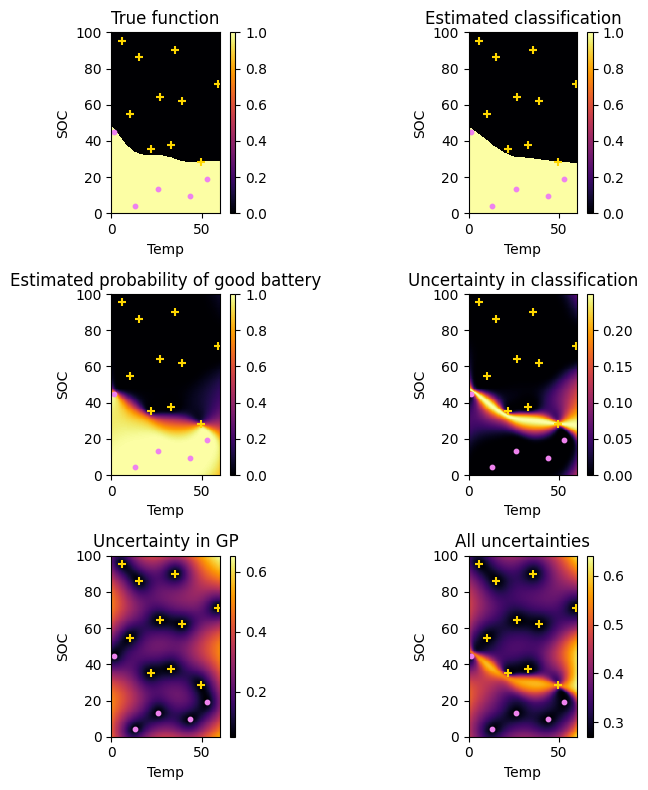

In [39]:
def visualize_model(X, Y, model, X_new=None):
    n_rows = 3
    n_cols = 2
    fig, axes = plt.subplots(n_rows,n_cols, tight_layout=True, figsize=(8,8))

    Xgrid = get_plotting_domain()
    Ygrid = lifetime_function(Xgrid) - threshold_lifetime
    
    plot_function(Ygrid > 0, axes[0,0])
    plot_white(X[Y.squeeze() > 0], axes[0,0])
    plot_gold(X[Y.squeeze() < 0], axes[0,0])
    axes[0,0].set_title("True function")

    prob, var, stddev = prediction(model, Xgrid)

    plot_function(prob > 0.5, axes[0,1])
    plot_white(X[Y.squeeze() > 0], axes[0,1])
    plot_gold(X[Y.squeeze() < 0], axes[0,1])
    axes[0,1].set_title("Estimated classification")

    plot_function(prob, axes[1,0])
    plot_white(X[Y.squeeze() > 0], axes[1,0])
    plot_gold(X[Y.squeeze() < 0], axes[1,0])
    axes[1,0].set_title("Estimated probability of good battery")

    plot_function(var, axes[1,1])
    plot_white(X[Y.squeeze() > 0], axes[1,1])
    plot_gold(X[Y.squeeze() < 0], axes[1,1])
    axes[1,1].set_title("Uncertainty in classification")

    plot_function(stddev, axes[2,0])
    plot_white(X[Y.squeeze() > 0], axes[2,0])
    plot_gold(X[Y.squeeze() < 0], axes[2,0])
    axes[2,0].set_title("Uncertainty in GP")

    plot_function(torch.distributions.Normal(0,1).cdf(stddev).pow(2) + var, axes[2,1])
    plot_white(X[Y.squeeze() > 0], axes[2,1])
    plot_gold(X[Y.squeeze() < 0], axes[2,1])
    axes[2,1].set_title("All uncertainties")

    if X_new is not None:
        for row in range(n_rows):
            for col in range(n_cols):
                plot_red(X_new, axes[row, col])
    plt.show()
    
visualize_model(X, Y, model)

# 3. Batch Design

In [40]:
def next_batch(
    sober,
    n_rec, 
    n_nys,
    batch_size,
    X_scaler
):
    X_cand = sober.prior.sample(n_rec)
    X_cand_standardized = torch.tensor(X_scaler.transform(X_cand), dtype=torch.double)
    _, var, stddev = prediction(sober.kernel.model, X_cand_standardized)
    uncertainty = torch.distributions.Normal(0,1).cdf(stddev).pow(2) + var
    weights = uncertainty / sober.prior.pdf(X_cand)
    weights = sober.cleansing_weights(weights)
    X_nys = sober.kmeans_resampling(X_cand_standardized, n_clusters=n_nys)
    
    idx_rchq, w_rchq = sober.sampling_recombination(
        X_cand_standardized,
        X_nys,
        weights,
        batch_size,
    )
    X_batch = X_cand[idx_rchq]
    return X_batch

In [41]:
from SOBER._sober import Sober

X_standardized = torch.tensor(X_scaler.transform(X), dtype=torch.double)
Y_normalized = torch.tensor(Y_scaler.transform(Y), dtype=torch.double)

model = setting_GP_model(X_standardized, Y_normalized)
sober = Sober(prior, model) # set SOBER wrapper

batch_size = 15    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_iterations = 4  # number of iterations (batches)
obj = None         # acquisition function

>>>>>> 1-th iteration


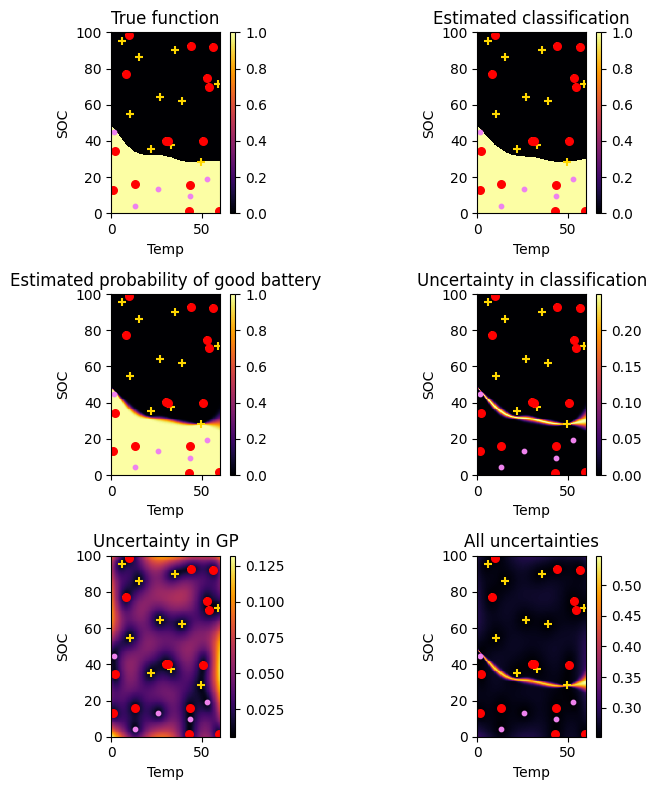

>>>>>> 2-th iteration


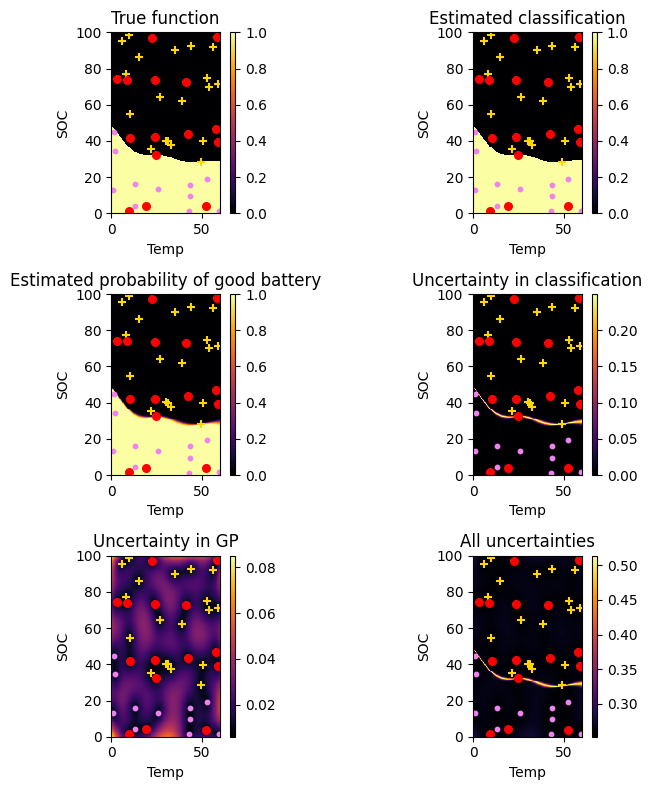

>>>>>> 3-th iteration


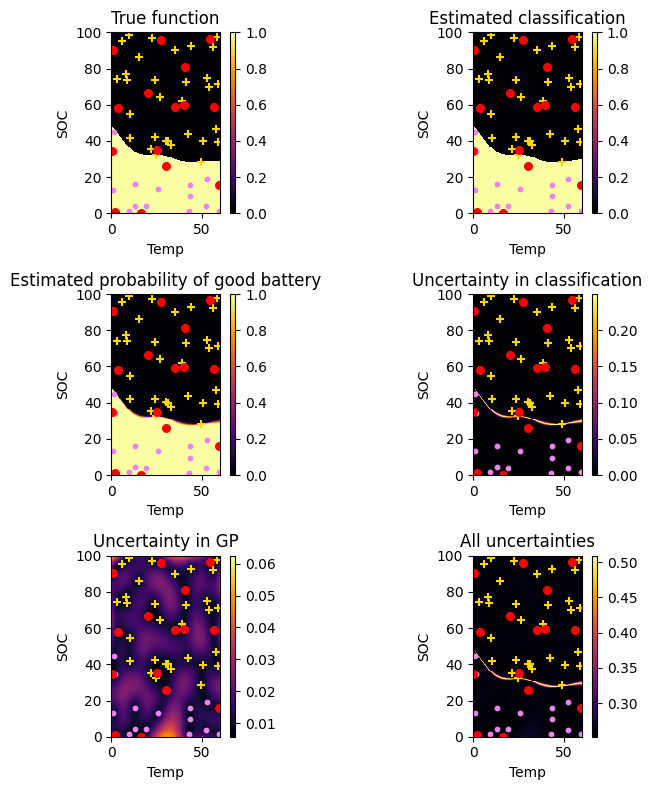

>>>>>> 4-th iteration


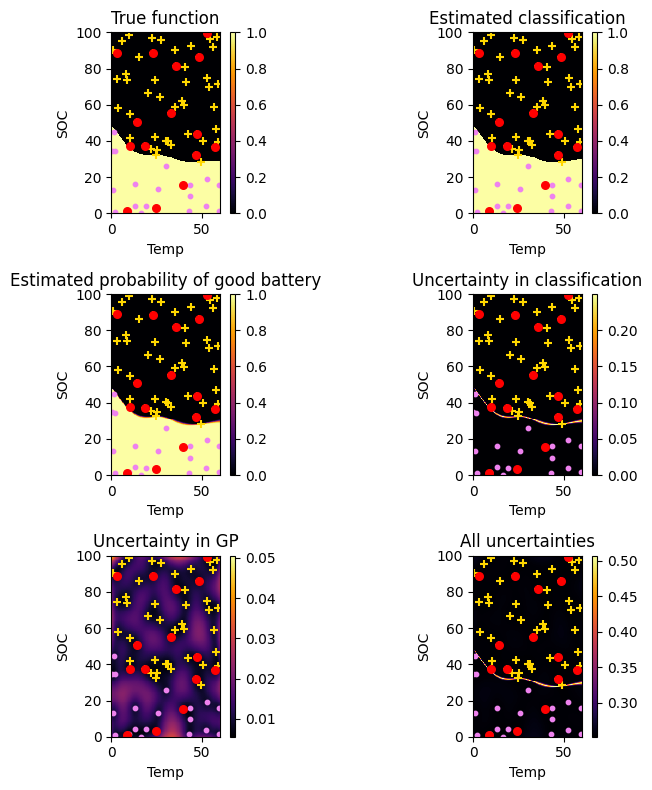

In [42]:
for i in range(n_iterations):
    X_next = next_batch(
        sober,
        n_rec,
        n_nys,
        batch_size,
        X_scaler
    ) # select the batch of next experiments
    Y_next = lifetime_function(X_next) - threshold_lifetime  # run experiment
    
    # merge results
    X = torch.vstack([X, X_next])
    Y = torch.vstack([Y, Y_next])
    
    # visualise the results
    X_standardized = torch.tensor(X_scaler.transform(X), dtype=torch.double)
    Y_normalized = torch.tensor(Y_scaler.transform(Y), dtype=torch.double)
    print(">>>>>> "+str(i +1)+"-th iteration")
    model = setting_GP_model(X_standardized, Y_normalized)   # Update and fit model
    sober.update_model(model)
    visualize_model(X, Y, model, X_new=X_next)